# Fight with all the imports for CMIP6 data

In [ ]:
# google colab installs

!pip install condacolab &> /dev/null
import condacolab
condacolab.install()

# install all packages in one call (+ use mamba instead of conda)
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# # properly install cartopy in colab to avoid session crash
!apt-get install libproj-dev proj-data proj-bin --quiet
!apt-get install libgeos-dev --quiet
!pip install cython --quiet
!pip install cartopy --quiet
!pip install geoviews

!apt-get -qq install python-cartopy python3-cartopy  --quiet
!pip uninstall -y shapely  --quiet
!pip install shapely --no-binary shapely  --quiet

!pip install boto3 --quiet

# you may need to restart the runtime after running this cell and that is ok

Reading package lists...
Building dependency tree...
Reading state information...
libproj-dev is already the newest version (8.2.1-1).
libproj-dev set to manually installed.
proj-data is already the newest version (8.2.1-1).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 154 kB of archives.
After this operation, 492 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 proj-bin amd64 8.2.1-1 [154 kB]
Fetched 154 kB in 1s (114 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 120901 files and directories currently installed.)
Preparing to unpack .../proj-bin_8.2.1-1_amd64.deb ...
Unpacking proj-bin (8.2.1-1) ...
Setting up proj-bin (8.2.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is alrea

In [ ]:
# imports

import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
from datatree import DataTree
from xmip.postprocessing import _parse_metric
import cartopy.crs as ccrs
import pooch
import os
import tempfile

In [ ]:
# print(intake.registry)

<Intake driver registry>


In [ ]:
# import sys
# print(sys.executable)

/usr/bin/python3.real


In [ ]:
# functions

%matplotlib inline

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data


def load_cmip6(source_id, variable_id, member_id, table_id):  # load selected model
    cat = col.search(
        source_id=source_ids,
        variable_id=variable_id,
        member_id=member_id,
        table_id=table_id,
        grid_label="gn",
        experiment_id=[
            "historical",
            "ssp126",
            "ssp245",
            "ssp585",
        ],  # downloading the scenarios out of the total 5+historical
        require_all_on=["source_id"],
    )

    kwargs = dict(
        preprocess=combined_preprocessing,
        xarray_open_kwargs=dict(use_cftime=True),
        storage_options={"token": "anon"},
    )
    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt

/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/ENSO' # this is different for each day
    user_temp_cache=tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# NOAA Dataset

In [ ]:
# # Ocean surface temprature
# filename_SST='sst.mnmean.nc'
# url_SST = 'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc'

# do_sst = xr.open_dataset(pooch_load(url_SST,filename_SST), drop_variables=['time_bnds'])

# # Precipitation rate (notice the units in the plot below)
# filename_prec_rate='precip.mon.mean.nc'
# url_prec_rate='https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc'
# do_pr = xr.open_dataset(pooch_load(url_prec_rate,filename_prec_rate))

# # Air Temperature Anomalies
# filename_tas='air.2x2.1200.mon.anom.comb.nc'
# url_tas='https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc'
# do_tas = xr.open_dataset(pooch_load(url_tas,filename_tas))

# CMIP6 Dataset

In [ ]:
cat = col.search(
    source_id="GFDL-ESM4",
    variable_id=[
        # "gpp",
        # "npp",
        # "nbp",
        # "treeFrac",
        # "grassFrac",
        "cropFrac",
        # "pastureFrac",
    ],  # No 'shrubFrac','baresoilFrac','residualFrac' in GFDL-ESM4
    member_id="r1i1p1f1",
    table_id="Lmon", #["Oclim", "Amon", "Omon", "Lmon", "Limon", "Oimon", "Aero", "cfMon"]
    grid_label="gr1",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_Lmon_variables = cat.to_datatree(**kwargs)

# convert to dataset instead of datatree, remove extra singleton dimensions
ds_Lmon = dt_Lmon_variables["GFDL-ESM4"]["historical"].to_dataset().squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [ ]:
ds = xr.Dataset()

# add land variables
for var in ds_Lmon.data_vars:
    ds[var] = ds_Lmon[var]


In [ ]:
# drop unnecessary coordinates
ds = ds.drop_vars(["member_id", "dcpp_init_year"])
ds

<xarray.Dataset>
Dimensions:   (y: 180, x: 288, time: 1980)
Coordinates:
  * y         (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x         (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time      (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lon       (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4 359.4
    lat       (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    cropFrac  (time, y, x) float32 dask.array<chunksize=(901, 180, 288), meta=np.ndarray>

# Get the monthly mean for Indonesia only

In [ ]:
# # take the timeseries
# ## Coordinates Indonesia

# x_ind = slice(95, 141) # longitude
# y_ind = slice(7,-12) # latitude

# ## SST

# sst_timeseries = do_sst.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
# sst_timeseries = sst_timeseries.mean(["lon", "lat"], keep_attrs=True)
# sst_timeseries_mean = np.array(sst_timeseries.sst)

# ## Air temp anomalies

# tas_timeseries = do_tas.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
# tas_timeseries = tas_timeseries.mean(["lon", "lat"], keep_attrs=True)
# tas_timeseries_mean = np.array(tas_timeseries.air)

# ## Precipitation

# rain_timeseries = do_pr.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
# rain_timeseries = rain_timeseries.mean(["lon", "lat"], keep_attrs=True)
# rain_timeseries_mean = np.array(rain_timeseries.precip)

# ## Crop fraction

# x_ind = slice(95, 141) # longitude
# y_ind = slice(-12,7) # latitude

# crop_frac_timeseries = ds.sel(time=slice('1979-07-01','2014-12-16'), y=y_ind, x=x_ind)
# crop_frac_timeseries = crop_frac_timeseries.mean(['y','x'], keep_attrs=True)
# crop_frac_timeseries_mean = np.array(crop_frac_timeseries.cropFrac)

In [ ]:
# ## Convert the xarray.datasets into pd.DataFrame
# from google.colab import files

# df_tas = tas_timeseries.to_dataframe()
# df_tas.to_csv('df_tas.csv', encoding = 'utf-8-sig')
# files.download('df_tas.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_sst = sst_timeseries.to_dataframe()
# df_sst.to_csv('df_sst.csv', encoding = 'utf-8-sig')
# files.download('df_sst.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_rain = rain_timeseries.to_dataframe()
# df_rain.to_csv('df_rain.csv', encoding = 'utf-8-sig')
# files.download('df_rain.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_crop = crop_frac_timeseries.to_dataframe()
# df_crop.to_csv('df_crop.csv', encoding = 'utf-8-sig')
# files.download('df_crop.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_tas

In [ ]:
# df_sst

,sst
time,
1979-07-01,27.735752
1979-08-01,27.539595
1979-09-01,27.833902
1979-10-01,28.360090
1979-11-01,28.893454
...,...
2014-08-01,28.089165
2014-09-01,28.228844
2014-10-01,28.645199


In [ ]:
# df_rain

,precip
time,
1979-07-01,5.431944
1979-08-01,3.386111
1979-09-01,5.865000
1979-10-01,5.342500
1979-11-01,8.013820
...,...
2014-08-01,5.148611
2014-09-01,3.842014
2014-10-01,4.140972


In [ ]:
# df_crop

,cropFrac
time,
1979-07-16 12:00:00,2.936973
1979-08-16 12:00:00,2.936973
1979-09-16 00:00:00,2.936973
1979-10-16 12:00:00,2.936973
1979-11-16 00:00:00,2.936973
...,...
2014-08-16 12:00:00,5.291160
2014-09-16 00:00:00,5.291160
2014-10-16 12:00:00,5.291160


# Download the DeepAR package

In [ ]:
# pip install "gluonts[torch]"

In [ ]:
pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [ ]:
# from gluonts.torch.model.deepar import DeepAREstimator
# from gluonts.dataset.common import ListDataset
# from gluonts.dataset.field_names import FieldName
# from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Run DeepAR

## Prepare the data: CMIP6

In [ ]:
import pandas as pd

Indonesia = pd.read_csv('Indonesia_timeseries_mean.csv')
Indonesia.head(2)

,time,cropFrac,gpp,grassFrac,nbp,npp,pastureFrac,treeFrac,nep,pr,rsds,rsus,tas,areacella
0,1850-01-16 12:00:00,0.655965,4.923347e-08,7.878640,-3.374646e-09,2.103969e-08,0.115874,12.365179,-2.800102e-09,0.000127,204.66885,13.699398,299.48627,1.536298e+10
1,1850-02-15 00:00:00,0.655965,5.173679e-08,7.948023,1.254644e-09,2.432577e-08,0.115874,12.368155,1.938519e-09,0.000120,206.91608,13.525014,299.32812,1.536298e+10


In [ ]:
rng = pd.date_range(start = '1850-01-01', end = '2015-01-01', freq='M')

In [ ]:
Indonesia.index = rng
Indonesia.head()

,time,cropFrac,gpp,grassFrac,nbp,npp,pastureFrac,treeFrac,nep,pr,rsds,rsus,tas,areacella
1850-01-31,1850-01-16 12:00:00,0.655965,4.923347e-08,7.878640,-3.374646e-09,2.103969e-08,0.115874,12.365179,-2.800102e-09,0.000127,204.66885,13.699398,299.48627,1.536298e+10
1850-02-28,1850-02-15 00:00:00,0.655965,5.173679e-08,7.948023,1.254644e-09,2.432577e-08,0.115874,12.368155,1.938519e-09,0.000120,206.91608,13.525014,299.32812,1.536298e+10
1850-03-31,1850-03-16 12:00:00,0.655965,5.405059e-08,8.028105,3.827634e-09,2.587070e-08,0.115874,12.369579,4.487882e-09,0.000123,208.66682,13.711241,299.33707,1.536298e+10
1850-04-30,1850-04-16 00:00:00,0.655965,5.238121e-08,8.111268,2.724934e-09,2.393364e-08,0.115874,12.373181,3.417906e-09,0.000116,209.31406,13.727771,299.73420,1.536298e+10
1850-05-31,1850-05-16 12:00:00,0.655965,5.258140e-08,8.176949,1.705504e-09,2.430349e-08,0.115874,12.378870,2.285713e-09,0.000078,211.94884,14.260654,299.64816,1.536298e+10


In [ ]:
Indonesia = Indonesia.drop(columns=['time', 'gpp','areacella', 'nbp', 'npp', 'nep'],axis=1)

In [ ]:
from gluonts.dataset.pandas import PandasDataset

ds_Indonesia_real = PandasDataset(dict(Indonesia), target='cropFrac', freq='M')

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
ds_Indonesia_real

PandasDataset<size=8, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

## Stationarity test

In [ ]:
from statsmodels.tsa.stattools import adfuller


for c in Indonesia.columns:
  print(c)
  result = adfuller(Indonesia[f'{c}'])
  print('ADF Statistic: %f' % result[0])
  if result[1]>0.05:
    print('unit root')
  else:
    print('no unit root')
  print('p-value: %f' % result[1])
  print()

cropFrac
ADF Statistic: 4.551206
unit root
p-value: 1.000000

grassFrac
ADF Statistic: -2.162340
unit root
p-value: 0.220197

pastureFrac
ADF Statistic: -0.802126
unit root
p-value: 0.818497

treeFrac
ADF Statistic: 3.658358
unit root
p-value: 1.000000

pr
ADF Statistic: -10.645509
no unit root
p-value: 0.000000

rsds
ADF Statistic: -10.635286
no unit root
p-value: 0.000000

rsus
ADF Statistic: -7.415093
no unit root
p-value: 0.000000

tas
ADF Statistic: -2.904577
no unit root
p-value: 0.044818



## Run the model with real data: CMIP6

In [ ]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 6.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
import mxnet as mx
import torch
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
import numpy as np

In [ ]:
def set_seed(seed):
    import os
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    mx.random.seed(seed)

set_seed(42)
estimator = DeepAREstimator(
    prediction_length=100,
    freq="M",
    trainer=Trainer(
        learning_rate=1e-3, epochs=5, num_batches_per_epoch=5
    ),
    # use_feat_static_cat=True,
    # cardinality=[len(cfip2idx), len(state2idx), len(county2idx)],
    use_feat_static_real=True
)

In [ ]:
ds_Indonesia_real = PandasDataset(dict(Indonesia), target="cropFrac", freq='M')

In [ ]:
estimator = DeepAREstimator(num_layers = 3,
    freq=ds_Indonesia_real.freq, prediction_length=100, trainer=Trainer(epochs=5)
)

In [ ]:
predictor = estimator.train(ds_Indonesia_real)
predictions = predictor.predict(ds_Indonesia_real)

100%|██████████| 50/50 [00:28<00:00,  1.76it/s, epoch=5/5, avg_epoch_loss=-.797]


### Evaluate the predictions

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_Indonesia_real,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

# we convert these generators to lists to ease the subsequent computations.
forecasts = list(forecast_it) ## forecasted time series
tss = list(ts_it) ## real time series

In [ ]:
test_entry = next(iter(forecasts))
print(test_entry)

In [ ]:
samples = test_entry.samples
ns, h = samples.shape
dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
r = Indonesia.shape[0]
x = pd.DataFrame(samples.T, index=dates)
x.columns = ['forecast']

df_original = pd.concat([x, Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
df_original.columns = ['forecast', 'real']
df_original['pred_error'] = df_original['forecast'] - df_original['real']
df_original['mape'] = (1/r)*((abs(df_original['forecast'] - df_original['real'])/abs(df_original['real'])))
err = np.array(df_original['pred_error'])

# print(x.index.min(), x.index.max())
# Indonesia.index.min()
# Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']

In [ ]:
Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac'].head(10)

2006-09-30    4.462581
2006-10-31    4.462581
2006-11-30    4.462581
2006-12-31    4.462581
2007-01-31    4.538285
2007-02-28    4.538285
2007-03-31    4.538285
2007-04-30    4.538285
2007-05-31    4.538285
2007-06-30    4.538285
Freq: M, Name: cropFrac, dtype: float64

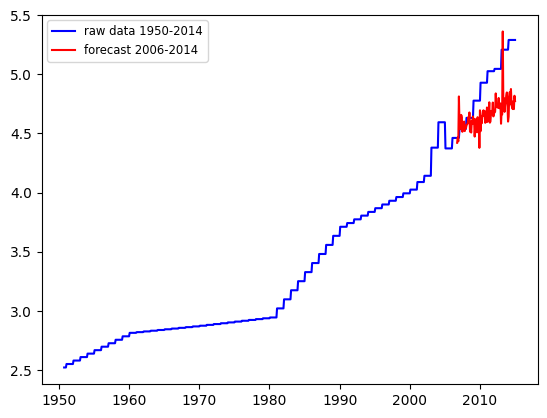

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(Indonesia.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00'].index, Indonesia.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac'], label='raw data 1950-2014', color='blue')
ax.plot(df_original.index, df_original['forecast'], label='forecast 2006-2014', color = 'red')
legend = ax.legend(loc='upper left', fontsize='small')
# df_original.head(10)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=df_original, x='pred_error', kind='kde')
plt.plot()
sns.displot(data=df_original, x='mape', kind='kde')
plt.plot()

In [ ]:
import json
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_real, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics_real, indent=4))

Running evaluation: 8it [00:00, 40.35it/s]


{
    "MSE": 46.618548442130795,
    "abs_error": 2344.8847850848515,
    "abs_target_sum": 54961.79462114671,
    "abs_target_mean": 68.70224327643339,
    "seasonal_error": 1.4610632452597756,
    "MASE": 11.112941658371476,
    "MAPE": 0.10068680794943909,
    "sMAPE": 0.09496833391324243,
    "MSIS": 444.517666334859,
    "QuantileLoss[0.1]": 3318.2564860125317,
    "Coverage[0.1]": 0.7024999999999999,
    "QuantileLoss[0.5]": 2344.8847850848515,
    "Coverage[0.5]": 0.7024999999999999,
    "QuantileLoss[0.9]": 1371.5130841571722,
    "Coverage[0.9]": 0.7024999999999999,
    "RMSE": 6.827777708898466,
    "NRMSE": 0.0993821654618455,
    "ND": 0.042663905013440924,
    "wQuantileLoss[0.1]": 0.06037387441377001,
    "wQuantileLoss[0.5]": 0.042663905013440924,
    "wQuantileLoss[0.9]": 0.02495393561311185,
    "mean_absolute_QuantileLoss": 2344.884785084852,
    "mean_wQuantileLoss": 0.042663905013440924,
    "MAE_Coverage": 0.33416666666666667,
    "OWA": NaN
}


## Run the model with differenced or detrended data: CMIP6

### Test again for stationarity when taking the differenced and the detrended data

In [ ]:
# Indonesia.head(2)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Indonesia['cropFrac'].diff(1))
plt.title('crop fraction')
plt.show()
plt.plot(Indonesia['grassFrac'].diff(1))
plt.title('grass fraction')
plt.show()
plt.plot(Indonesia['pastureFrac'].diff(1))
plt.title('pasture fraction')
plt.show()
plt.plot(Indonesia['treeFrac'].diff(1))
plt.title('tree fraction')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(Indonesia['cropFrac'], model='additive')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['grassFrac'], model='additive')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['pastureFrac'], model='additive')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['treeFrac'], model='additive')
result.plot()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(Indonesia['cropFrac'], model='multiplicative')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['grassFrac'], model='multiplicative')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['pastureFrac'], model='multiplicative')
result.plot()
plt.show()

result = seasonal_decompose(Indonesia['treeFrac'], model='multiplicative')
result.plot()
plt.show()


In [ ]:
## ADF test using difference data


from statsmodels.tsa.stattools import adfuller


columns = ['grassFrac', 'treeFrac','cropFrac', 'pastureFrac']

for c in columns:
  #x = Indonesia[f'{c}'].diff(1)
  x = Indonesia[f'{c}'] - Indonesia[f'{c}'].shift(12, fill_value=0)
  x = x[1:]
  print(c)
  result = adfuller(x)
  print('ADF Statistic: %f' % result[0])
  if result[1]>0.05:
    print('unit root')
  else:
    print('no unit root')
  print('p-value: %f' % result[1])
  #plt.plot(x)
  #plt.show()
  print()

grassFrac
ADF Statistic: -12.604555
no unit root
p-value: 0.000000

treeFrac
ADF Statistic: -6.789927
no unit root
p-value: 0.000000

cropFrac
ADF Statistic: -5.301023
no unit root
p-value: 0.000005

pastureFrac
ADF Statistic: -4.879591
no unit root
p-value: 0.000038



In [ ]:
# ## ADF test using detrended data

# from statsmodels.tsa.stattools import adfuller
# from scipy.signal import detrend

# ## from the plots above it looks like only these two can be detrended

# columns = ['cropFrac', 'pastureFrac']

# for c in columns:
#   x = detrend(Indonesia[f'{c}'], type='linear', bp=0, overwrite_data=False)
#   x = x[1:]
#   print(c)
#   result = adfuller(x)
#   print('ADF Statistic: %f' % result[0])
#   if result[1]>0.05:
#     print('unit root')
#   else:
#     print('no unit root')
#   print('p-value: %f' % result[1])
#   print()

### Run the model with all stationary data

In [ ]:
# from gluonts.dataset.pandas import PandasDataset

Indonesia_diff = Indonesia.copy()

columns = ['grassFrac', 'treeFrac','cropFrac', 'pastureFrac']

for c in columns:
  x = Indonesia_diff[f'{c}'] - Indonesia_diff[f'{c}'].shift(12, fill_value=0)
  Indonesia_diff[f'{c}'] = round(x[1:],10)
  Indonesia_diff = Indonesia_diff

Indonesia_diff.head(5)
ds_Indonesia_diff = PandasDataset(dict(Indonesia_diff[1:]), target='cropFrac', freq='M')

In [ ]:
def set_seed(seed):
    import os
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    mx.random.seed(seed)

set_seed(42)
estimator = DeepAREstimator(
    prediction_length=100,
    freq="M",
    trainer=Trainer(
        learning_rate=1e-3, epochs=5, num_batches_per_epoch=5
    ),
    # use_feat_static_cat=True,
    # cardinality=[len(cfip2idx), len(state2idx), len(county2idx)],
    use_feat_static_real=True
)

In [ ]:
estimator = DeepAREstimator(num_layers=3,
    freq=ds_Indonesia_diff.freq, prediction_length=100, trainer=Trainer(epochs=5)
)

In [ ]:
predictor = estimator.train(ds_Indonesia_diff)
predictions = predictor.predict(ds_Indonesia_diff)

100%|██████████| 50/50 [00:28<00:00,  1.77it/s, epoch=5/5, avg_epoch_loss=-1.85]


In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_Indonesia_diff,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

# we convert these generators to lists to ease the subsequent computations.
forecasts = list(forecast_it) ## forecasted time series
tss = list(ts_it) ## real time series

In [ ]:
test_entry = next(iter(forecasts))
# print(test_entry)
test_entry.samples.shape

(1, 100)

In [ ]:
samples = test_entry.samples
ns, h = samples.shape
dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
r = Indonesia_diff.shape[0]
x = pd.DataFrame(samples.T, index=dates)
x.columns = ['forecast']

df_diff = pd.concat([x, Indonesia_diff.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
df_diff.columns = ['forecast', 'real']
df_diff['pred_error'] = df_diff['forecast'] - df_diff['real']
df_diff['mape'] = (1/r)*((abs(df_diff['forecast'] - df_diff['real'])/abs(df_diff['real'])))
err_diff = np.array(df_diff['pred_error'])

# print(x.index.min(), x.index.max())
# Indonesia.index.min()
# Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']

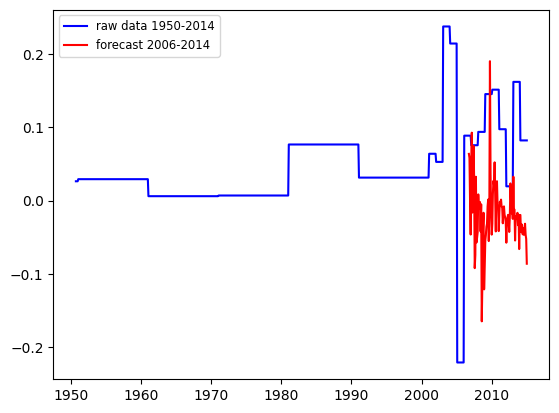

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(Indonesia_diff.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00'].index, Indonesia_diff.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac'], label='raw data 1950-2014', color='blue')
ax.plot(df_diff.index, df_diff['forecast'], label='forecast 2006-2014', color = 'red')
legend = ax.legend(loc='upper left', fontsize='small')
# df_original.head(10)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=df_diff, x='pred_error', kind='kde')
plt.show()
sns.displot(data=df_diff, x='mape', kind='kde')
plt.show()

In [ ]:
import json
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_real, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics_real, indent=4))

Running evaluation: 8it [00:00, 86.81it/s]


{
    "MSE": 45.40186176885263,
    "abs_error": 2128.002209111275,
    "abs_target_sum": 52872.00587738671,
    "abs_target_mean": 66.09000734673339,
    "seasonal_error": 1.4807135939023315,
    "MASE": 6.595739464115861,
    "MAPE": 259.75686345726285,
    "sMAPE": 0.8023386054145494,
    "MSIS": 263.8295785646345,
    "QuantileLoss[0.1]": 2361.336892689151,
    "Coverage[0.1]": 0.41125,
    "QuantileLoss[0.5]": 2128.002209111275,
    "Coverage[0.5]": 0.41125,
    "QuantileLoss[0.9]": 1894.667525533401,
    "Coverage[0.9]": 0.41125,
    "RMSE": 6.738090365144462,
    "NRMSE": 0.10195323976579197,
    "ND": 0.04024818377510089,
    "wQuantileLoss[0.1]": 0.04466138277721541,
    "wQuantileLoss[0.5]": 0.04024818377510089,
    "wQuantileLoss[0.9]": 0.03583498477298641,
    "mean_absolute_QuantileLoss": 2128.0022091112755,
    "mean_wQuantileLoss": 0.0402481837751009,
    "MAE_Coverage": 0.29625,
    "OWA": NaN
}


## Run the model with standardised data

In [ ]:
# from gluonts.dataset.pandas import PandasDataset

Indonesia_stand = Indonesia.copy()

from sklearn.preprocessing import StandardScaler


for c in Indonesia_stand.columns:
  scaler= StandardScaler()
  scale = scaler.fit_transform(Indonesia_stand[[f'{c}']])
  Indonesia_stand[f'{c}'] = scale


Indonesia_stand.head(5)
ds_Indonesia_stand = PandasDataset(dict(Indonesia_stand), target='cropFrac', freq='M')

In [ ]:
estimator = DeepAREstimator(num_layers=3,
    freq=ds_Indonesia_stand.freq, prediction_length=100, trainer=Trainer(epochs=5)
)

In [ ]:
predictor = estimator.train(ds_Indonesia_stand)
predictions = predictor.predict(ds_Indonesia_stand)

100%|██████████| 50/50 [00:28<00:00,  1.73it/s, epoch=5/5, avg_epoch_loss=-.115]


In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_Indonesia_stand,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

# we convert these generators to lists to ease the subsequent computations.
forecasts = list(forecast_it) ## forecasted time series
tss = list(ts_it) ## real time series

In [ ]:
test_entry = next(iter(forecasts))
print(test_entry)

gluonts.model.forecast.SampleForecast(info=None, item_id='cropFrac', samples=array([[1.8191879, 2.0830638, 1.9985267, 1.9507674, 1.9305148, 1.8427184,
        1.8983963, 1.8586046, 1.9276729, 2.0374377, 1.9580868, 1.8186845,
        1.9879376, 2.0773203, 1.9475788, 2.0509508, 2.1283538, 2.108048 ,
        2.0253832, 2.2578084, 2.1085224, 2.1055355, 2.0983682, 2.0899055,
        2.0732882, 2.0799177, 2.195261 , 2.307719 , 2.1923182, 2.1791382,
        2.2588265, 2.2660232, 2.476509 , 2.140647 , 2.3537843, 2.2485065,
        2.1923254, 2.2261088, 2.2612774, 2.570791 , 2.4612958, 2.4057858,
        2.4936328, 2.4605784, 2.455898 , 2.2977355, 2.489446 , 2.3937109,
        2.5160916, 2.5525103, 2.5230808, 2.7513347, 2.6074233, 2.7081716,
        2.5278168, 2.5817914, 2.6046295, 2.500153 , 2.5125232, 2.4488573,
        2.6571817, 2.5608406, 2.9348707, 2.7607381, 2.733408 , 2.7408664,
        2.832473 , 2.750595 , 2.7618635, 2.6481462, 2.4784508, 2.9048867,
        2.717698 , 2.722541 , 2.741

In [ ]:
samples = test_entry.samples
ns, h = samples.shape
dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
r = Indonesia.shape[0]
x = pd.DataFrame(samples.T, index=dates)
x.columns = ['forecast']

df_stand = pd.concat([x, Indonesia_stand.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
df_stand.columns = ['forecast', 'real']
df_stand['pred_error'] = df_stand['forecast'] - df_stand['real']
df_stand['mape'] = (1/r)*((abs(df_stand['forecast'] - df_stand['real'])/abs(df_stand['real'])))
err = np.array(df_stand['pred_error'])

# print(x.index.min(), x.index.max())
# Indonesia.index.min()
# Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']

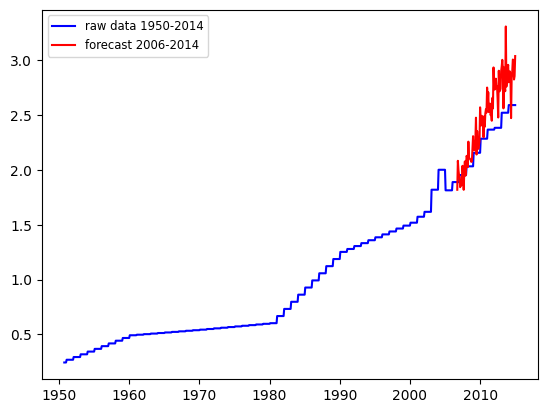

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(Indonesia_stand.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00'].index, Indonesia_stand.loc['1950-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac'], label='raw data 1950-2014', color='blue')
ax.plot(df_stand.index, df_stand['forecast'], label='forecast 2006-2014', color = 'red')
legend = ax.legend(loc='upper left', fontsize='small')
# df_original.head(10)

[]

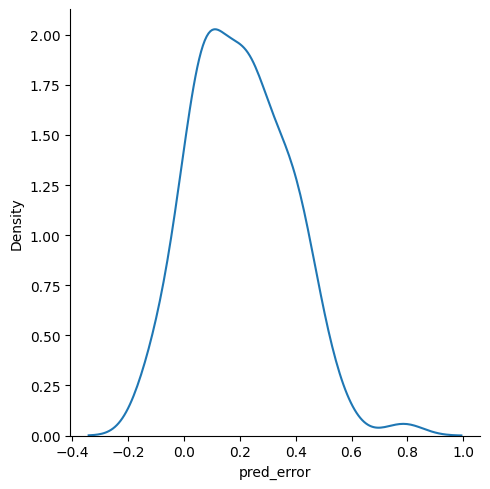

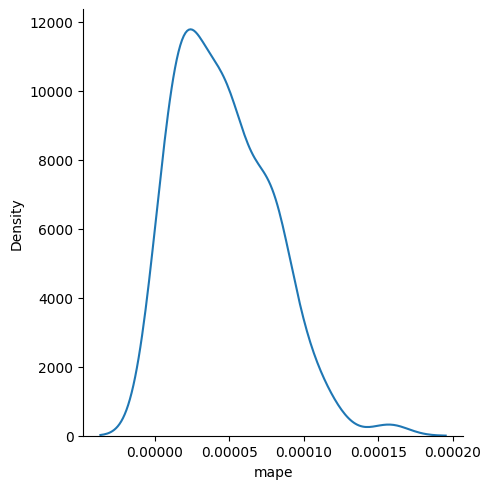

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=df_stand, x='pred_error', kind='kde')
plt.plot()
sns.displot(data=df_stand, x='mape', kind='kde')
plt.plot()

In [ ]:
import json
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_real, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics_real, indent=4))

Running evaluation: 8it [00:00, 87.49it/s]


{
    "MSE": 0.9644156476180745,
    "abs_error": 542.5766340109466,
    "abs_target_sum": 1123.0010322507526,
    "abs_target_mean": 1.4037512903134408,
    "seasonal_error": 0.38264155637383657,
    "MASE": 4.750776976334413,
    "MAPE": 1.3141056271936638,
    "sMAPE": 0.7025250767922311,
    "MSIS": 190.03107905337654,
    "QuantileLoss[0.1]": 597.045892704072,
    "Coverage[0.1]": 0.5925,
    "QuantileLoss[0.5]": 542.5766340109466,
    "Coverage[0.5]": 0.5925,
    "QuantileLoss[0.9]": 488.10737531782115,
    "Coverage[0.9]": 0.5925,
    "RMSE": 0.9820466626479999,
    "NRMSE": 0.6995873623943175,
    "ND": 0.48314882927889935,
    "wQuantileLoss[0.1]": 0.5316521317059296,
    "wQuantileLoss[0.5]": 0.48314882927889935,
    "wQuantileLoss[0.9]": 0.4346455268518691,
    "mean_absolute_QuantileLoss": 542.5766340109466,
    "mean_wQuantileLoss": 0.4831488292788994,
    "MAE_Coverage": 0.29750000000000004,
    "OWA": NaN
}


## Import deep knockoffs

In [ ]:
## Upload the deep knockoffs previously created
import pandas as pd

knockoffs_m = pd.read_csv('knockoffs_m-2.csv')
knockoffs_g = pd.read_csv('knockoffs_g-2.csv')

In [ ]:
knockoffs_m.head(2)

,Unnamed: 0,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
0,0,-1.311593,0.581892,-1.443124,1.343272,1.769781,-0.637171,-1.318627,-0.457622
1,1,-1.247986,1.840458,-1.656552,1.358629,0.983982,-0.339060,-0.733178,-0.131025


In [ ]:
knockoffs_m.drop('Unnamed: 0', axis='columns', inplace=True)
knockoffs_g.drop('Unnamed: 0', axis='columns', inplace=True)

In [ ]:
knockoffs_m.columns

Index(['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds',
       'rsus', 'tas'],
      dtype='object')

In [ ]:
knockoffs_g.columns

Index(['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds',
       'rsus', 'tas'],
      dtype='object')

In [ ]:
knockoffs_m.index = Indonesia.index
knockoffs_g.index = Indonesia.index
knockoffs_m.tail(2)

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2014-11-30,2.452295,-1.909213,1.215625,-2.106913,-0.433704,0.582804,1.074258,0.700165
2014-12-31,2.893851,-2.776336,0.813983,-2.144781,0.439225,-0.908220,-0.178236,1.721312


In [ ]:
Indonesia.tail(2)

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2014-11-30,5.29116,7.169642,0.906812,7.853476,0.000082,224.58406,15.785722,300.53494
2014-12-31,5.29116,7.182526,0.906812,7.858041,0.000117,198.69928,14.439017,300.37585


In [ ]:
knockoffs_g.tail(2)

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2014-11-30,2.590852,-3.635984,1.187252,-1.927367,-0.267747,0.224535,1.235824,1.855935
2014-12-31,2.590844,-3.940076,1.187322,-1.923968,1.518208,-0.689324,-0.160355,2.774974


## Run the model with deep knockoffs and original data

In [ ]:
## include also the pred_errors inside a dataframe for all knockoff substitutions
errors = []
mape = []

for c in Indonesia.columns:

  i = Indonesia.shape[1]
  r = Indonesia.shape[0]

  Indonesia_copy = Indonesia.copy()
  Indonesia_copy[c] = knockoffs_g[c]
  ds_Indonesia_kn = PandasDataset(dict(Indonesia_copy), target='cropFrac', freq='M')

  ## run the estimator
  estimator = DeepAREstimator(num_layers=3,freq=ds_Indonesia_kn.freq, prediction_length=100, trainer=Trainer(epochs=5))
  predictor = estimator.train(ds_Indonesia_kn)
  predictions = predictor.predict(ds_Indonesia_kn)

  forecast_it, ts_it = make_evaluation_predictions(dataset=ds_Indonesia_kn, predictor=predictor, num_samples=1)  # number of sample paths we want for evaluation
  forecasts = list(forecast_it)
  tss = list(ts_it)


  test_entry = next(iter(forecasts))
  # print(test_entry)
  test_entry.samples.shape

  samples = test_entry.samples
  ns, h = samples.shape
  dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
  x = pd.DataFrame(samples.T, index=dates)
  x.columns = [f'forecast_{c}']

  df3 = pd.concat([x, Indonesia.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
  df3.columns = [f'forecast_{c}', 'real']
  df3[f'pred_error_{c}'] = df3[f'forecast_{c}'] - df3['real']
  df3[f'MAPE_{c}'] = (1/r)*((abs(df3[f'forecast_{c}'] - df3['real'])/abs(df3['real'])))
  #errors = errors.append({f'pred_error_{c}': df3[f'pred_error_{c}']}, ignore_index=True)
  errors.append(df3[f'pred_error_{c}'])
  mape.append(df3[f'MAPE_{c}'])



  # evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
  # agg_metrics, item_metrics = evaluator(tss, forecasts)
  # CSS = round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4)
  # CSS = np.log(CSS)
  # print(f'agg_metrics {c} / agg_metrics_real :')
  # print(CSS)
  #print(round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4))
  #print(json.dumps(agg_metrics_{c}, indent=4))

100%|██████████| 50/50 [00:29<00:00,  1.70it/s, epoch=5/5, avg_epoch_loss=-.325]


In [ ]:
#er = pd.DataFrame(errors[0])
df_errors = pd.concat([errors[0], errors[1], errors[2], errors[3], errors[4], errors[5], errors[6], errors[7]],axis=1, ignore_index=True, sort=False)
df_errors.columns = ['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds', 'rsus', 'tas']
df_errors.head()

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2006-09-30,-2.679987,-0.051096,-0.010989,0.208262,-0.036891,-0.128516,-0.051067,-0.061408
2006-10-31,-2.611710,-0.023685,0.100417,-0.114210,-0.112800,-0.242142,-0.063658,-0.114703
2006-11-30,-2.547257,0.057271,-0.092618,-0.056116,-0.144608,-0.140022,-0.011364,-0.135734
2006-12-31,-2.251817,-0.059516,0.025293,-0.126680,-0.168794,-0.093077,0.083405,0.132729
2007-01-31,-2.653767,-0.161404,-0.282432,-0.048757,-0.199574,-0.148994,-0.099114,-0.130794


In [ ]:
#er = pd.DataFrame(errors[0])
df_mape = pd.concat([mape[0], mape[1], mape[2], mape[3], mape[4], mape[5], mape[6], mape[7]],axis=1, ignore_index=True, sort=False)
df_mape.columns = ['mape_cropFrac', 'mape_grassFrac', 'mape_pastureFrac', 'mape_treeFrac', 'mape_pr', 'mape_rsds', 'mape_rsus', 'mape_tas']
df_mape.head()

,mape_cropFrac,mape_grassFrac,mape_pastureFrac,mape_treeFrac,mape_pr,mape_rsds,mape_rsus,mape_tas
2006-09-30,0.000303,0.000006,0.000001,0.000024,0.000004,0.000015,0.000006,0.000007
2006-10-31,0.000296,0.000003,0.000011,0.000013,0.000013,0.000027,0.000007,0.000013
2006-11-30,0.000288,0.000006,0.000010,0.000006,0.000016,0.000016,0.000001,0.000015
2006-12-31,0.000255,0.000007,0.000003,0.000014,0.000019,0.000011,0.000009,0.000015
2007-01-31,0.000295,0.000018,0.000031,0.000005,0.000022,0.000017,0.000011,0.000015


In [ ]:
df_mape.columns

Index(['mape_cropFrac', 'mape_grassFrac', 'mape_pastureFrac', 'mape_treeFrac',
       'mape_pr', 'mape_rsds', 'mape_rsus', 'mape_tas'],
      dtype='object')

In [ ]:
for c in df_mape.columns:
  df_mape[f'CSS_{c}'] = np.log(df_mape[f'{c}']/df_original['mape'])

In [ ]:
from statsmodels.stats.weightstats import ztest
alpha = 0.05
columns = ['CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas']


for c in columns:

  #sample_mean = np.mean(df_mape[f'{c}'])
  sample_mean = 0
  # sample_size = np.std(df_mape_stat[f'{c}'])
  ztest_score, pval = ztest(df_mape[f'{c}'],value=sample_mean,alternative='larger')

  print(f'{c}')
  print(round(pval,10))

  # if (pval>alpha):
  #   print('Null hypothesis is accepted!')
  # elif (pval<=alpha):
  #   print('Null hypothesis is rejected. \nAlternate hypothesis is accepted!');

CSS_mape_cropFrac
0.0
CSS_mape_grassFrac
7.7439e-06
CSS_mape_pastureFrac
0.0
CSS_mape_treeFrac
0.9330518044
CSS_mape_pr
0.0
CSS_mape_rsds
0.0
CSS_mape_rsus
4.51e-08
CSS_mape_tas
0.0


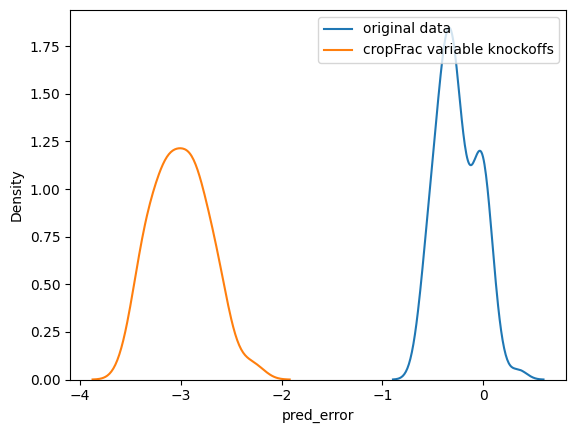

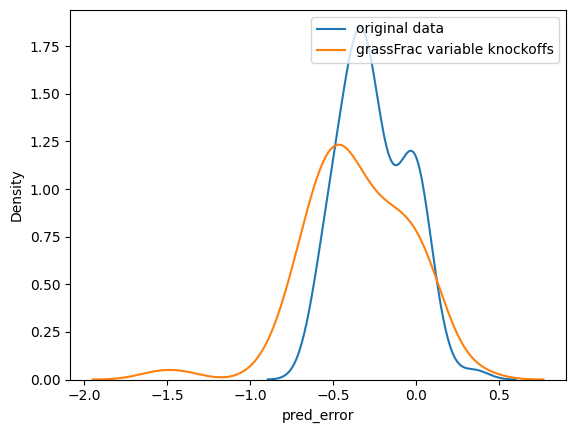

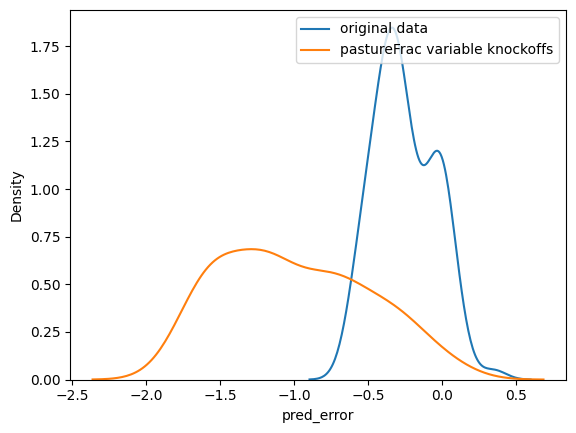

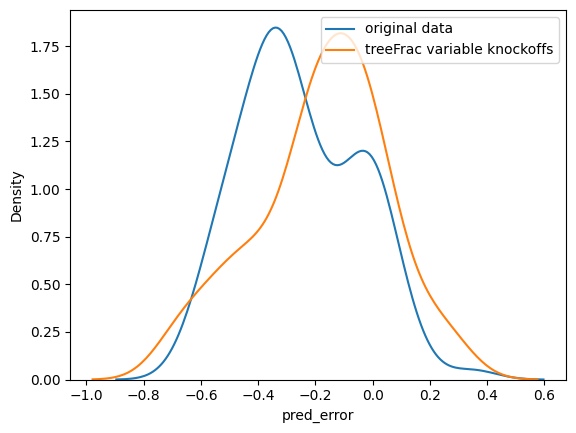

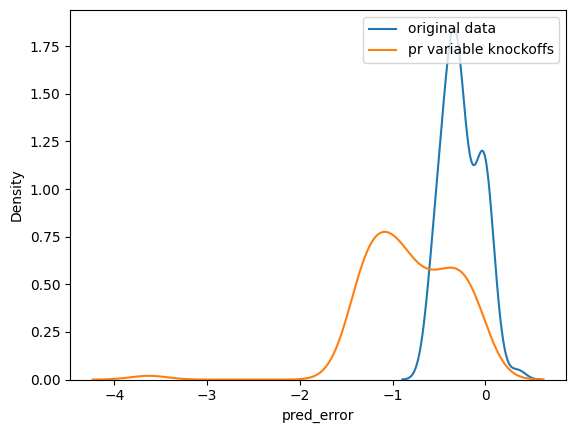

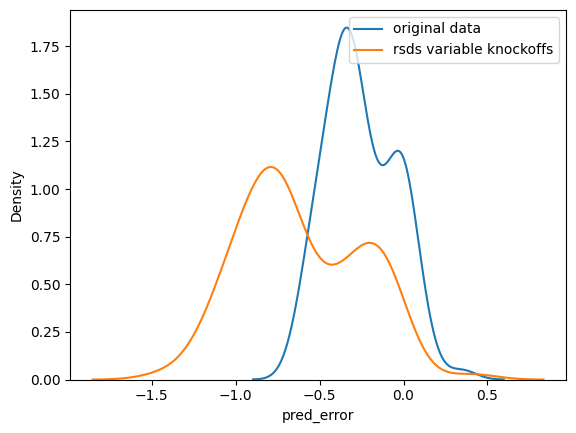

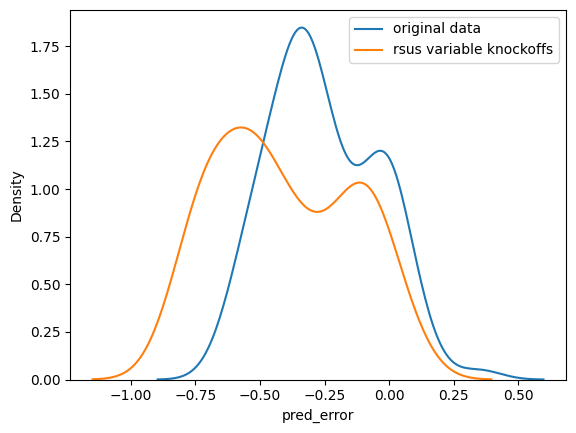

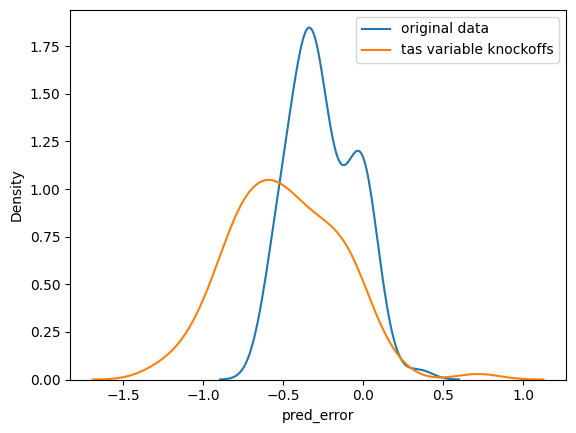

In [ ]:
import seaborn as sns

for c in df_errors.columns:
  ax = plt.axes()
  sns.kdeplot(df_original['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_errors[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
for c in df_mape.columns:
  ax = plt.axes()
  #sns.kdeplot(df3['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_mape[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
## KS causality test
import scipy.stats as st

for c in df_errors.columns:
  t, p = st.kstest(np.array(df_errors[f'{c}']), np.array(df_original['pred_error']))
  print(f'{c}')
  print(f'Test statistic: {t}, p-value: {round(p,4)}')

  if p < 0.10:
    print(f'Null hypothesis is rejected: {c} does not cause crop Fraction changes')
  else:
    print(f'Fail to reject null hypothesis: evidence {c} causes crop Fraction changes ')
  print()

cropFrac
Test statistic: 1.0, p-value: 0.0
Null hypothesis is rejected: cropFrac does not cause crop Fraction changes

grassFrac
Test statistic: 0.25, p-value: 0.0037
Null hypothesis is rejected: grassFrac does not cause crop Fraction changes

pastureFrac
Test statistic: 0.76, p-value: 0.0
Null hypothesis is rejected: pastureFrac does not cause crop Fraction changes

treeFrac
Test statistic: 0.29, p-value: 0.0004
Null hypothesis is rejected: treeFrac does not cause crop Fraction changes

pr
Test statistic: 0.63, p-value: 0.0
Null hypothesis is rejected: pr does not cause crop Fraction changes

rsds
Test statistic: 0.59, p-value: 0.0
Null hypothesis is rejected: rsds does not cause crop Fraction changes

rsus
Test statistic: 0.35, p-value: 0.0
Null hypothesis is rejected: rsus does not cause crop Fraction changes

tas
Test statistic: 0.42, p-value: 0.0
Null hypothesis is rejected: tas does not cause crop Fraction changes



## Run the model with deep knockoffs and stationary data

In [ ]:
## include also the pred_errors inside a dataframe for all knockoff substitutions
errors_stat = []
mape_stat = []

for c in Indonesia_diff.columns:

  i = Indonesia_diff.shape[1]
  r = Indonesia_diff.shape[0]

  Indonesia_copy_stat = Indonesia_diff.copy()
  Indonesia_copy_stat[c] = knockoffs_g[c]
  ds_Indonesia_kn_stat = PandasDataset(dict(Indonesia_copy_stat), target='cropFrac', freq='M')

  ## run the estimator
  estimator = DeepAREstimator(num_layers=3, freq=ds_Indonesia_kn_stat.freq, prediction_length=100, trainer=Trainer(epochs=10))
  predictor = estimator.train(ds_Indonesia_kn_stat)
  predictions = predictor.predict(ds_Indonesia_kn_stat)

  forecast_it, ts_it = make_evaluation_predictions(dataset=ds_Indonesia_kn_stat, predictor=predictor, num_samples=1)  # number of sample paths we want for evaluation
  forecasts = list(forecast_it)
  tss = list(ts_it)


  test_entry = next(iter(forecasts))
  # print(test_entry)
  test_entry.samples.shape

  samples = test_entry.samples
  ns, h = samples.shape
  dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
  x = pd.DataFrame(samples.T, index=dates)
  x.columns = ['forecast']

  df_errors_stat = pd.concat([x, Indonesia_diff.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
  df_errors_stat.columns = [f'forecast_{c}', 'real']
  df_errors_stat[f'pred_error_{c}'] = df_errors_stat[f'forecast_{c}'] - df_errors_stat['real']
  df_errors_stat[f'MAPE_{c}'] = (1/r)*((abs(df_errors_stat[f'forecast_{c}'] - df_errors_stat['real'])/abs(df_errors_stat['real'])))
  #errors = errors.append({f'pred_error_{c}': df3[f'pred_error_{c}']}, ignore_index=True)
  errors_stat.append(df_errors_stat[f'pred_error_{c}'])
  mape_stat.append(df_errors_stat[f'MAPE_{c}'])



  # evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
  # agg_metrics, item_metrics = evaluator(tss, forecasts)
  # CSS = round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4)
  # CSS = np.log(CSS)
  # print(f'agg_metrics {c} / agg_metrics_real :')
  # print(CSS)
  #print(round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4))
  #print(json.dumps(agg_metrics_{c}, indent=4))

 64%|██████▍   | 32/50 [00:20<00:11,  1.53it/s, epoch=6/10, avg_epoch_loss=-1.96]

In [ ]:
#er = pd.DataFrame(errors[0])
df_errors_stat = pd.concat([errors_stat[0], errors_stat[1], errors_stat[2], errors_stat[3], errors_stat[4], errors_stat[5], errors_stat[6], errors_stat[7]],axis=1, ignore_index=True, sort=False)
df_errors_stat.columns = ['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds', 'rsus', 'tas']
df_errors_stat.head()

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2006-09-30,1.733754,-0.091864,-0.061844,0.333544,-0.131266,-0.050559,-0.197673,-0.076834
2006-10-31,1.801337,-0.039701,-0.095656,-0.508322,0.015786,0.010284,-0.099030,-0.136018
2006-11-30,2.334620,-0.071378,-0.062747,-0.047449,0.068417,-0.016647,0.116452,0.035177
2006-12-31,1.956115,-0.021575,-0.005912,-0.055481,0.011821,-0.065008,-0.736957,0.050830
2007-01-31,1.889333,-0.081795,-0.055179,-0.125436,-0.053780,-0.109350,-0.039202,0.031661


In [ ]:
#er = pd.DataFrame(errors[0])
df_mape_stat = pd.concat([mape_stat[0], mape_stat[1], mape_stat[2], mape_stat[3], mape_stat[4], mape_stat[5], mape_stat[6], mape_stat[7]],axis=1, ignore_index=True, sort=False)
df_mape_stat.columns = ['mape_cropFrac', 'mape_grassFrac', 'mape_pastureFrac', 'mape_treeFrac', 'mape_pr', 'mape_rsds', 'mape_rsus', 'mape_tas']
df_mape_stat.head()

,mape_cropFrac,mape_grassFrac,mape_pastureFrac,mape_treeFrac,mape_pr,mape_rsds,mape_rsus,mape_tas
2006-09-30,0.009862,0.000523,0.000352,0.001897,0.000747,0.000288,0.001124,0.000437
2006-10-31,0.010246,0.000226,0.000544,0.002891,0.000090,0.000058,0.000563,0.000774
2006-11-30,0.013280,0.000406,0.000357,0.000270,0.000389,0.000095,0.000662,0.000200
2006-12-31,0.011127,0.000123,0.000034,0.000316,0.000067,0.000370,0.004192,0.000289
2007-01-31,0.012604,0.000546,0.000368,0.000837,0.000359,0.000730,0.000262,0.000211


In [ ]:
for c in df_mape_stat.columns:
  df_mape_stat[f'CSS_{c}'] = np.log(df_mape_stat[f'{c}']/df_diff['mape'])

In [ ]:
columns = ['CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas']

for c in df_mape_stat.columns:
  #ax = plt.axes()
  sns.kdeplot(df_mape_stat[f'{c}'], label=f'MAPE_{c}')
  # sns.kdeplot(df_diff['pred_error'], ax=ax, label='differenced data')
  # sns.kdeplot(df_errors_stat[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  #plt.legend(loc='upper right')
  plt.show();

In [ ]:
# df_mape_stat['CSS_mape_cropFrac']
# df_mape_stat['mape_cropFrac']
# df_diff['mape']
# np.log(df_mape_stat['mape_cropFrac']/df_diff['mape'])

In [ ]:
from statsmodels.stats.weightstats import ztest
alpha = 0.05
columns = ['CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas']


for c in columns:

  # sample_mean = np.mean(df_mape_stat[f'{c}'])
  sample_mean = 0
  # sample_size = np.std(df_mape_stat[f'{c}'])
  ztest_score, pval = ztest(df_mape_stat[f'{c}'],value=sample_mean,alternative='larger')

  print(f'{c}')
  print(round(pval,5))

  # if (pval>alpha):
  #   print('Null hypothesis is accepted!')
  # elif (pval<=alpha):
  #   print('Null hypothesis is rejected. \nAlternate hypothesis is accepted!');

CSS_mape_cropFrac
0.0
CSS_mape_grassFrac
3e-05
CSS_mape_pastureFrac
0.00188
CSS_mape_treeFrac
0.00143
CSS_mape_pr
1.0
CSS_mape_rsds
1e-05
CSS_mape_rsus
0.55225
CSS_mape_tas
0.08585


In [ ]:
# df_mape_stat.columns

Index(['mape_cropFrac', 'mape_grassFrac', 'mape_pastureFrac', 'mape_treeFrac',
       'mape_pr', 'mape_rsds', 'mape_rsus', 'mape_tas', 'CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas'],
      dtype='object')

In [ ]:
for c in df_errors_stat.columns:
  ax = plt.axes()
  sns.kdeplot(df_original['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_diff['pred_error'], ax=ax, label='differenced data')
  sns.kdeplot(df_errors_stat[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
for c in df_mape_stat.columns:
  ax = plt.axes()
  #sns.kdeplot(df3['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_mape_stat[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
## KS causality test
import scipy.stats as st

for c in df_errors_stat.columns:
  t, p = st.kstest(np.array(df_errors_stat[f'{c}']), np.array(df_original['pred_error']))
  print(f'{c}')
  print(f'Test statistic: {t}, p-value: {round(p,4)}')

  if p < 0.10:
    print(f'Null hypothesis is rejected: {c} does not cause crop Fraction changes')
  else:
    print(f'Fail to reject null hypothesis: evidence {c} causes crop Fraction changes ')
  print()

In [ ]:
## Granger causality test



## Run the model with deep knockoffs and standardised data

In [ ]:
Indonesia_stand.columns

Index(['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds',
       'rsus', 'tas'],
      dtype='object')

In [ ]:
## include also the pred_errors inside a dataframe for all knockoff substitutions
errors_stat = []
mape_stat = []

for c in Indonesia_stand.columns:

  i = Indonesia_stand.shape[1]
  r = Indonesia_stand.shape[0]

  Indonesia_copy_stat = Indonesia_stand.copy()
  Indonesia_copy_stat[c] = knockoffs_g[c]
  ds_Indonesia_kn_stat = PandasDataset(dict(Indonesia_copy_stat), target='cropFrac', freq='M')

  ## run the estimator
  estimator = DeepAREstimator(num_layers=3, freq=ds_Indonesia_kn_stat.freq, prediction_length=100, trainer=Trainer(epochs=10))
  predictor = estimator.train(ds_Indonesia_kn_stat)
  predictions = predictor.predict(ds_Indonesia_kn_stat)

  forecast_it, ts_it = make_evaluation_predictions(dataset=ds_Indonesia_kn_stat, predictor=predictor, num_samples=1)  # number of sample paths we want for evaluation
  forecasts = list(forecast_it)
  tss = list(ts_it)


  test_entry = next(iter(forecasts))
  # print(test_entry)
  test_entry.samples.shape

  samples = test_entry.samples
  ns, h = samples.shape
  dates = pd.date_range(test_entry.start_date.to_timestamp(), freq=test_entry.freq, periods=h)
  x = pd.DataFrame(samples.T, index=dates)
  x.columns = ['forecast']

  df_errors_stat = pd.concat([x, Indonesia_stand.loc['2006-09-30 00:00:00':'2014-12-31 00:00:00','cropFrac']],axis=1, ignore_index=True, sort=False)
  df_errors_stat.columns = [f'forecast_{c}', 'real']
  df_errors_stat[f'pred_error_{c}'] = df_errors_stat[f'forecast_{c}'] - df_errors_stat['real']
  df_errors_stat[f'MAPE_{c}'] = (1/r)*((abs(df_errors_stat[f'forecast_{c}'] - df_errors_stat['real'])/abs(df_errors_stat['real'])))
  #errors = errors.append({f'pred_error_{c}': df3[f'pred_error_{c}']}, ignore_index=True)
  errors_stat.append(df_errors_stat[f'pred_error_{c}'])
  mape_stat.append(df_errors_stat[f'MAPE_{c}'])



  # evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
  # agg_metrics, item_metrics = evaluator(tss, forecasts)
  # CSS = round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4)
  # CSS = np.log(CSS)
  # print(f'agg_metrics {c} / agg_metrics_real :')
  # print(CSS)
  #print(round(agg_metrics['MAPE']/agg_metrics_real['MAPE'],4))
  #print(json.dumps(agg_metrics_{c}, indent=4))

In [ ]:
#er = pd.DataFrame(errors[0])
df_errors_stand = pd.concat([errors_stat[0], errors_stat[1], errors_stat[2], errors_stat[3], errors_stat[4], errors_stat[5], errors_stat[6], errors_stat[7]],axis=1, ignore_index=True, sort=False)
df_errors_stand.columns = ['cropFrac', 'grassFrac', 'pastureFrac', 'treeFrac', 'pr', 'rsds', 'rsus', 'tas']
df_errors_stand.head()

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
2006-09-30,-0.064241,-0.050538,0.015448,-0.095476,-0.108863,0.058460,-0.016512,-0.113871
2006-10-31,-0.186766,-0.090743,-0.029478,-0.133045,-0.116411,0.033451,0.044535,-0.098329
2006-11-30,-0.128141,-0.062276,0.079107,-0.033463,-0.092391,-0.009094,0.083399,0.073424
2006-12-31,-0.146009,-0.061834,0.018388,-0.092865,-0.110839,0.098490,0.024387,0.069222
2007-01-31,-0.179844,0.268873,-0.027392,-0.143736,-0.107650,-0.041817,-0.007875,-0.054012


In [ ]:
#er = pd.DataFrame(errors[0])
df_mape_stand = pd.concat([mape_stat[0], mape_stat[1], mape_stat[2], mape_stat[3], mape_stat[4], mape_stat[5], mape_stat[6], mape_stat[7]],axis=1, ignore_index=True, sort=False)
df_mape_stand.columns = ['mape_cropFrac', 'mape_grassFrac', 'mape_pastureFrac', 'mape_treeFrac', 'mape_pr', 'mape_rsds', 'mape_rsus', 'mape_tas']
df_mape_stand.head()

,mape_cropFrac,mape_grassFrac,mape_pastureFrac,mape_treeFrac,mape_pr,mape_rsds,mape_rsus,mape_tas
2006-09-30,0.000017,0.000014,0.000004,0.000026,0.000029,0.000016,0.000004,0.000030
2006-10-31,0.000050,0.000024,0.000008,0.000036,0.000031,0.000009,0.000012,0.000026
2006-11-30,0.000034,0.000017,0.000021,0.000009,0.000025,0.000002,0.000022,0.000020
2006-12-31,0.000039,0.000017,0.000005,0.000025,0.000030,0.000026,0.000007,0.000019
2007-01-31,0.000047,0.000070,0.000007,0.000037,0.000028,0.000011,0.000002,0.000014


In [ ]:
for c in df_mape_stand.columns:
  df_mape_stand[f'CSS_{c}'] = np.log(df_mape_stand[f'{c}']/df_stand['mape'])

In [ ]:
columns = ['CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas']

for c in df_mape_stand.columns:
  #ax = plt.axes()
  sns.kdeplot(df_mape_stand[f'{c}'], label=f'MAPE_{c}')
  # sns.kdeplot(df_diff['pred_error'], ax=ax, label='differenced data')
  # sns.kdeplot(df_errors_stat[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  #plt.legend(loc='upper right')
  plt.show();

In [ ]:
from statsmodels.stats.weightstats import ztest
alpha = 0.05
columns = ['CSS_mape_cropFrac',
       'CSS_mape_grassFrac', 'CSS_mape_pastureFrac', 'CSS_mape_treeFrac',
       'CSS_mape_pr', 'CSS_mape_rsds', 'CSS_mape_rsus', 'CSS_mape_tas']


for c in columns:

  # sample_mean = np.mean(df_mape_stat[f'{c}'])
  sample_mean = 0
  # sample_size = np.std(df_mape_stat[f'{c}'])
  ztest_score, pval = ztest(df_mape_stand[f'{c}'],value=sample_mean,alternative='larger')

  print(f'{c}')
  print(round(pval,5))

  # if (pval>alpha):
  #   print('Null hypothesis is accepted!')
  # elif (pval<=alpha):
  #   print('Null hypothesis is rejected. \nAlternate hypothesis is accepted!');

CSS_mape_cropFrac
0.0
CSS_mape_grassFrac
0.0
CSS_mape_pastureFrac
1.0
CSS_mape_treeFrac
0.0
CSS_mape_pr
0.0
CSS_mape_rsds
1.0
CSS_mape_rsus
0.963
CSS_mape_tas
0.0


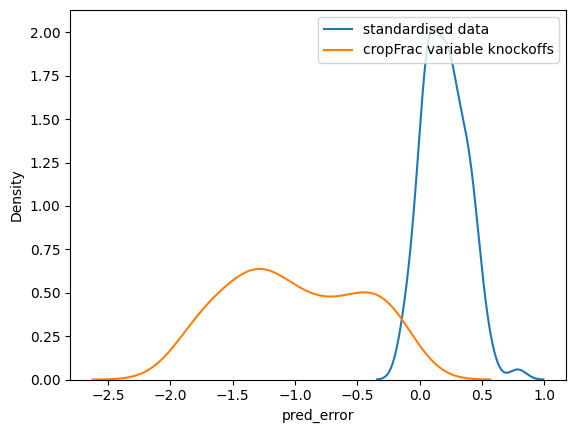

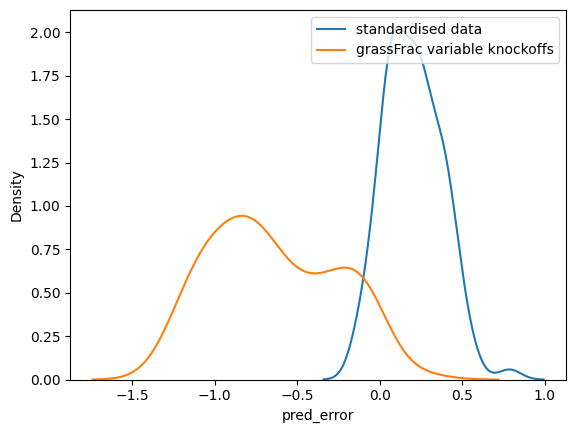

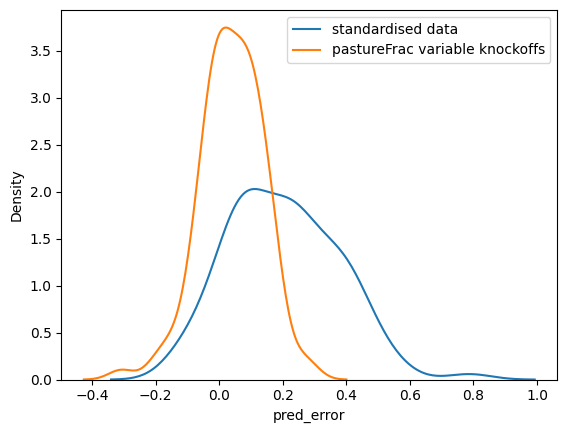

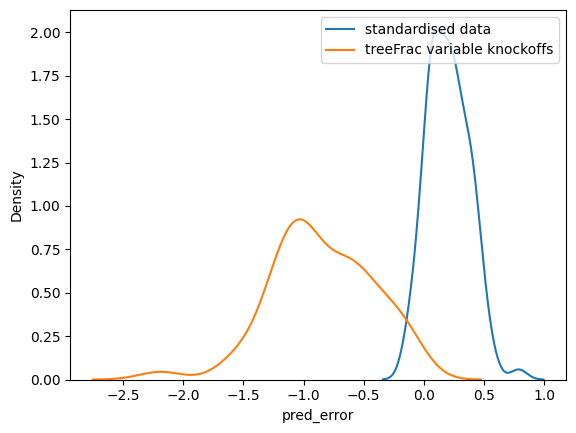

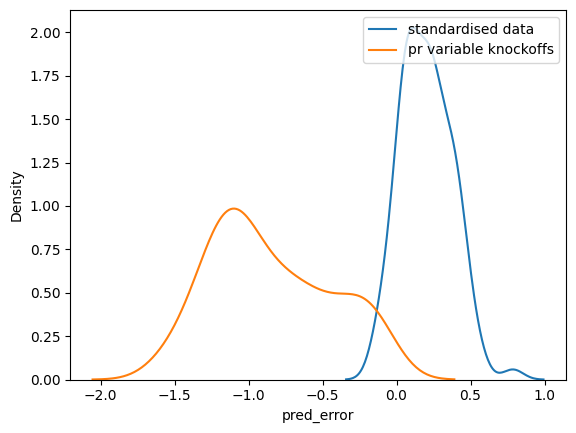

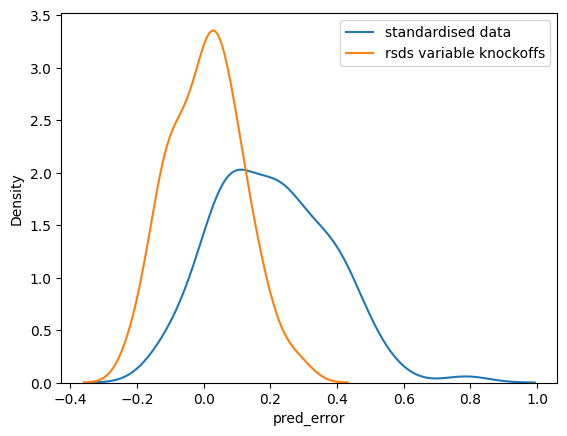

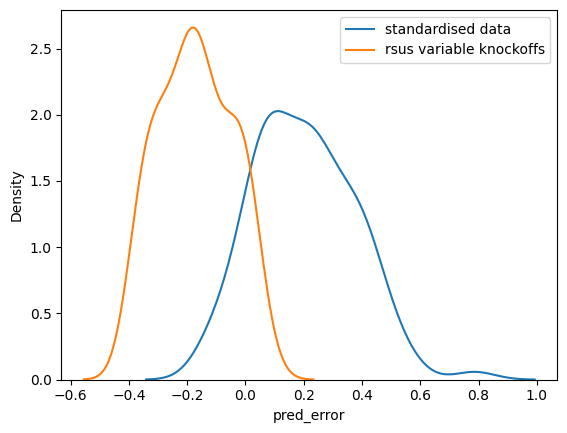

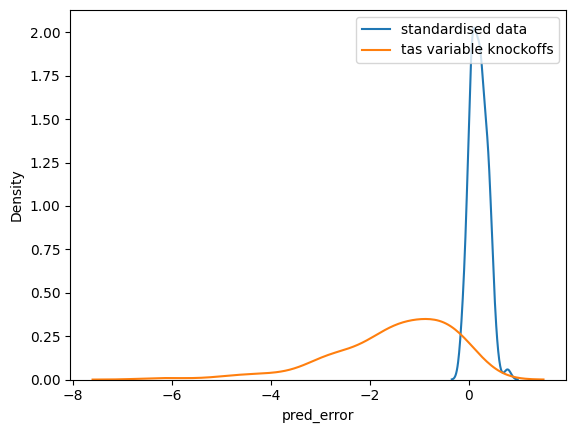

In [ ]:
for c in df_errors_stand.columns:
  ax = plt.axes()
  #sns.kdeplot(df_original['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_stand['pred_error'], ax=ax, label='standardised data')
  sns.kdeplot(df_errors_stand[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
for c in df_mape_stand.columns:
  ax = plt.axes()
  #sns.kdeplot(df3['pred_error'], ax=ax, label='original data')
  sns.kdeplot(df_mape_stand[f'{c}'], ax=ax, label=f'{c} variable knockoffs')
  #sns.kdeplot(SD_frame_D, ax=ax)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
## KS causality test
import scipy.stats as st

for c in df_errors_stand.columns:
  t, p = st.kstest(np.array(df_errors_stand[f'{c}']), np.array(df_stand['pred_error']))
  print(f'{c}')
  print(f'Test statistic: {t}, p-value: {round(p,4)}')

  if p < 0.10:
    print(f'Null hypothesis is rejected: {c} does not cause crop Fraction changes')
  else:
    print(f'Fail to reject null hypothesis: evidence {c} causes crop Fraction changes ')
  print()

cropFrac
Test statistic: 0.98, p-value: 0.0
Null hypothesis is rejected: cropFrac does not cause crop Fraction changes

grassFrac
Test statistic: 0.91, p-value: 0.0
Null hypothesis is rejected: grassFrac does not cause crop Fraction changes

pastureFrac
Test statistic: 0.5, p-value: 0.0
Null hypothesis is rejected: pastureFrac does not cause crop Fraction changes

treeFrac
Test statistic: 0.96, p-value: 0.0
Null hypothesis is rejected: treeFrac does not cause crop Fraction changes

pr
Test statistic: 0.96, p-value: 0.0
Null hypothesis is rejected: pr does not cause crop Fraction changes

rsds
Test statistic: 0.51, p-value: 0.0
Null hypothesis is rejected: rsds does not cause crop Fraction changes

rsus
Test statistic: 0.83, p-value: 0.0
Null hypothesis is rejected: rsus does not cause crop Fraction changes

tas
Test statistic: 0.92, p-value: 0.0
Null hypothesis is rejected: tas does not cause crop Fraction changes

